In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer

c:\Users\USER\OneDrive - UNIVERSITAS INDONESIA\COOLYEAH\smt 8\tugas akhir\topic-modelling\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_01 = pd.read_csv('data/stemmed_merged_kubu_01.csv')
df_01['created_at'] = pd.to_datetime(df_01['created_at'])
df_01['date'] = df_01['created_at'].dt.date


In [3]:
indo_stopwords = [
    # Basic Indonesian stopwords (keep these)
    "yang", "dan", "di", "dengan", "untuk", "dari", "ke", "pada", "ini", "itu",
    "atau", "ada", "juga", "dalam", "saya", "kamu", "anda", "mereka", "kita", "kami",
    "dia", "nya", "adalah", "akan", "oleh", "seperti", "telah", "sudah", "bisa", "dapat",
    "tidak", "tak", "jangan", "ya", "via", "yg", "dgn", "utk", "dr", "pd", "dlm", "sdh", "tdk",
    
    # All candidate names and variations (since they appear everywhere)
    "anies", "baswedan", "rasyid", "muhaimin", "iskandar", "cak", "imin", "gus", 
    "prabowo", "subianto", "gibran", "rakabuming", "raka", "ganjar", "pranowo", 
    "mahfud", "md", "gama", "mawi", "abdurrahman", "abdul", "amin"
    
    # Titles and name prefixes
    "mas", "pak", "bu", "bapak", "ibu", "om", "tante", "mbak", "bro", "sis", "bang", 
    "abang", "kak", "adek", "adik", "kakak", "bung", "prof", "dr", "haji", "hajah", "h",
    
    # Social media expressions
    "rt", "dm", "pm", "cc", "wkwk", "haha", "woi", "hey", "ah", "eh", "oh", "hmm", "btw",
    "omg", "lol", "sih", "aja", "gitu", "banget", "kok", "deh", "ih", "yuk", "mantap",
    "insya", "insyaallah", "alhamdulillah", "bismillah", "amin", "allahuma", "allah",
    
    # Locations
    "jakarta", "jawa", "barat", "timur", "tengah", "utara", "selatan", "sumatra", "bali", 
    "aceh", "kota", "desa", "daerah", "wilayah", "provinsi", "kabupaten", "kawasan",
    "bandung", "surabaya", "makassar", "balikpapan", "semarang", "yogyakarta", "solo",
    
    

]

In [4]:

vectorizer = CountVectorizer(
    stop_words=indo_stopwords,
    ngram_range=(1, 3),  # Keep bigrams and trigrams for political phrases
    min_df=5,            # Lower threshold to capture more specific topics
    max_df=0.7           # Stricter upper bound to remove very common terms
)

# Configure UMAP for better clustering of political content
umap_model = UMAP(
    n_neighbors=15,      # Smaller neighborhood for more specific clusters
    n_components=5,      
    min_dist=0.0,        # Adjusted for better separation
    metric='cosine',
    random_state=42
)

# More sensitive clustering for political topics
hdbscan_model = HDBSCAN(
    min_cluster_size=10,  # Smaller clusters to capture specific campaign themes
    min_samples=5,       # More lenient sample requirement
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# Improved c-TF-IDF weighting
ctfidf_model = ClassTfidfTransformer(
    reduce_frequent_words=True,
    bm25_weighting=True
)

embedding_model = SentenceTransformer(
    'distiluse-base-multilingual-cased-v1'
)

# Configure BERTopic for Indonesian political content
topic_model = BERTopic(
    language="multilingual",  # Keep multilingual for Indonesian
    calculate_probabilities=True,
    verbose=True,
    nr_topics=15,             # Reduced from 15 to get more focused topics
    min_topic_size=10,         # Smaller topics to capture campaign themes
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    ctfidf_model=ctfidf_model,
    vectorizer_model=vectorizer,
    embedding_model=embedding_model,
)

timestamps = df_01['created_at'].tolist()

# Fit the model
topics, probs = topic_model.fit_transform(df_01['full_text'].tolist())

2025-05-24 00:04:32,890 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 934/934 [05:06<00:00,  3.04it/s]
2025-05-24 00:09:40,052 - BERTopic - Embedding - Completed ✓
2025-05-24 00:09:40,052 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-24 00:10:31,932 - BERTopic - Dimensionality - Completed ✓
2025-05-24 00:10:31,935 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-24 00:19:09,959 - BERTopic - Cluster - Completed ✓
2025-05-24 00:19:09,960 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-24 00:19:11,104 - BERTopic - Representation - Completed ✓
2025-05-24 00:19:11,105 - BERTopic - Topic reduction - Reducing number of topics
2025-05-24 00:19:11,136 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-24 00:19:11,993 - BERTopic - Representation - Completed ✓
2025-05-24 00:19:11,997 - BERTopic - Topic reduction - Re

In [5]:
# Generate more meaningful topic labels
topic_labels = {}
for topic_id in topic_model.get_topic_info()["Topic"]:
    if topic_id == -1:
        topic_labels[topic_id] = "Outlier"
        continue
        
    # Get top words for the topic
    words = [word for word, _ in topic_model.get_topic(topic_id)[:5]]
    
    # Map topics to campaign themes based on keywords
    if any(term in words for term in ["palestina", "doa", "israel", "gaza"]):
        topic_labels[topic_id] = "Isu Palestina"
    elif any(term in words for term in ["aceh", "bandara", "kedatagan", "sambut"]):
        topic_labels[topic_id] = "Kampanye di Aceh"
    elif any(term in words for term in ["sumbar", "sumatra", "barat", "bukittinggi"]):
        topic_labels[topic_id] = "Kampanye Sumatra Barat"
    elif any(term in words for term in ["adil", "makmur", "sejahtera", "ekonomi"]):
        topic_labels[topic_id] = "Visi Ekonomi"
    elif any(term in words for term in ["islam", "muslim", "santri", "kiai"]):
        topic_labels[topic_id] = "Dukungan Religius"
    elif any(term in words for term in ["pesantren", "santri", "ulama"]):
        topic_labels[topic_id] = "Dukungan Pesantren"
    elif any(term in words for term in ["konstitusi", "mk", "etik"]):
        topic_labels[topic_id] = "Polemik MK"
    elif any(term in words for term in ["solo", "jakarta", "gubernur"]):
        topic_labels[topic_id] = "Kinerja Kepemimpinan"
    elif any(term in words for term in ["elektabilitas", "survei", "unggul"]):
        topic_labels[topic_id] = "Elektabilitas & Polling"
    elif any(term in words for term in ["debat", "pidato", "bicara"]):
        topic_labels[topic_id] = "Debat & Pidato"
    else:
        # Use top 3 words as label
        topic_labels[topic_id] = " & ".join(words[:3])

# Apply custom labels
topic_model.set_topic_labels(topic_labels)

In [6]:

from wordcloud import WordCloud

In [6]:
# Extract topics over time
topics_over_time = topic_model.topics_over_time(
    docs=df_01['full_text'].tolist(),
    timestamps=timestamps,
    global_tuning=True,
    evolution_tuning=True,
    nr_bins=20
)

# Group by date and topic
df_01['topic'] = topics
df_grouped = df_01.groupby([df_01['created_at'].dt.date, 'topic']).size().reset_index(name='count')

# Filter out the outlier topic
df_filtered = df_grouped[df_grouped['topic'] != -1]

# Get top 8 topics (excluding outlier)
top_topics = topic_model.get_topic_info().query("Topic != -1").head(8)['Topic'].tolist()

# Filter to just include top topics
df_top = df_filtered[df_filtered['topic'].isin(top_topics)]

# Create a pivot table
pivot_df = df_top.pivot(index='created_at', columns='topic', values='count').fillna(0)

# Replace topic IDs with labels in column names
pivot_df.columns = [topic_labels.get(col, f"Topic {col}") for col in pivot_df.columns]

20it [00:01, 18.16it/s]


In [8]:
from wordcloud import WordCloud
import seaborn as sns

<Figure size 1600x1000 with 0 Axes>

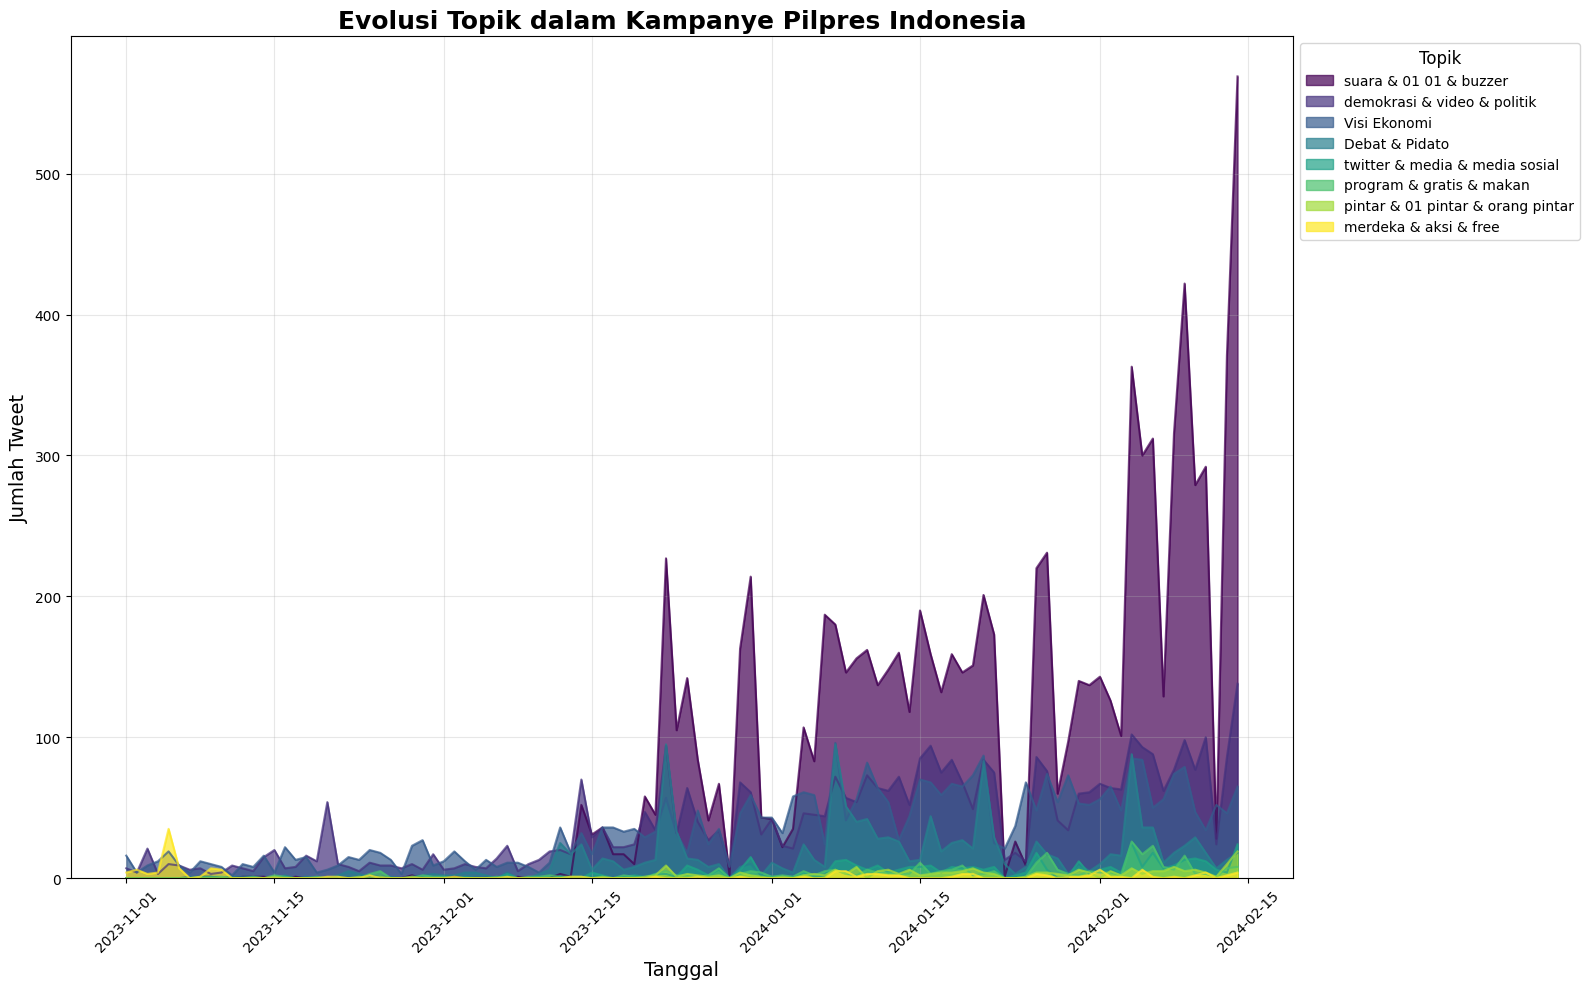

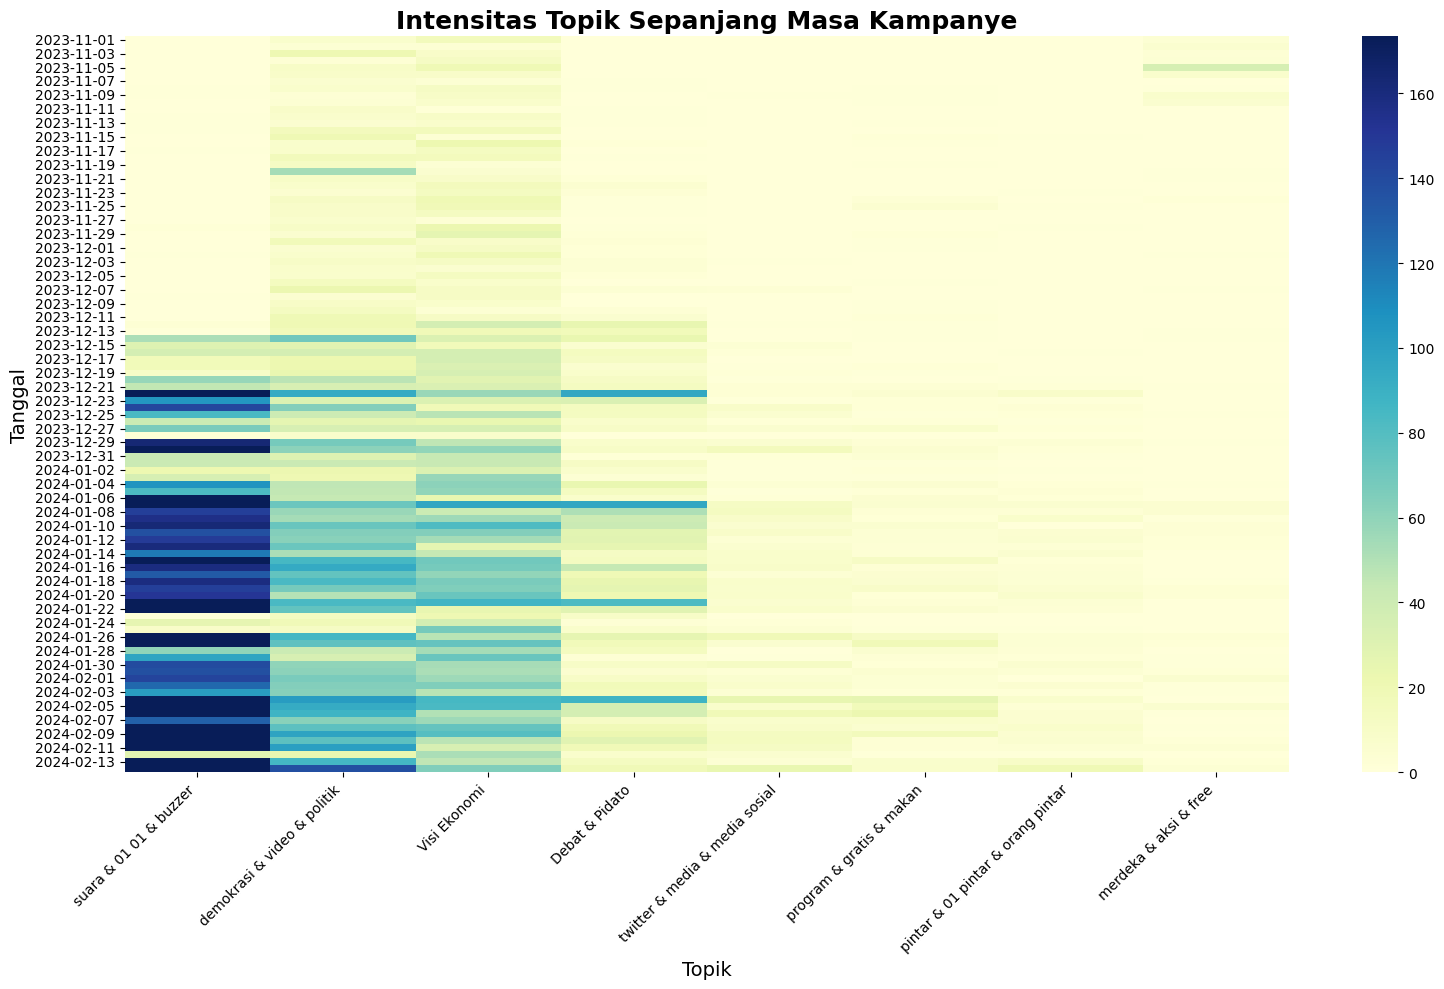

In [9]:
# Create a stacked area chart for topic trends
plt.figure(figsize=(16, 10))
pivot_df.plot.area(stacked=False, alpha=0.7, figsize=(16, 10), colormap='viridis')
plt.title('Evolusi Topik dalam Kampanye Pilpres Indonesia', fontsize=18, fontweight='bold')
plt.xlabel('Tanggal', fontsize=14)
plt.ylabel('Jumlah Tweet', fontsize=14)
plt.legend(title='Topik', title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a heatmap showing topic intensity over time
plt.figure(figsize=(16, 10))
sns.heatmap(pivot_df, cmap="YlGnBu", robust=True)
plt.title('Intensitas Topik Sepanjang Masa Kampanye', fontsize=18, fontweight='bold')
plt.ylabel('Tanggal', fontsize=14)
plt.xlabel('Topik', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [10]:
# Find dates with significant topic shifts
topic_shifts = []
for topic in pivot_df.columns:
    for i in range(1, len(pivot_df)):
        if pivot_df[topic].iloc[i] > pivot_df[topic].iloc[i-1] * 2 and pivot_df[topic].iloc[i] > 20:
            topic_shifts.append({
                'date': pivot_df.index[i],
                'topic': topic,
                'change': round(pivot_df[topic].iloc[i] / pivot_df[topic].iloc[i-1], 2)
            })

# Sort by magnitude of change
topic_shifts_df = pd.DataFrame(topic_shifts).sort_values('change', ascending=False)

print("\nSignificant Topic Shifts:")
for idx, row in topic_shifts_df.head(10).iterrows():
    print(f"Date: {row['date']}, Topic: {row['topic']}, Change: {row['change']}x increase")


Significant Topic Shifts:
Date: 2023-12-29, Topic: suara & 01 01 & buzzer, Change: 81.5x increase
Date: 2023-12-14, Topic: suara & 01 01 & buzzer, Change: 52.0x increase
Date: 2024-01-24, Topic: suara & 01 01 & buzzer, Change: 26.0x increase
Date: 2024-01-26, Topic: suara & 01 01 & buzzer, Change: 24.44x increase
Date: 2024-02-13, Topic: suara & 01 01 & buzzer, Change: 13.25x increase
Date: 2024-02-04, Topic: program & gratis & makan, Change: 13.0x increase
Date: 2024-01-07, Topic: Debat & Pidato, Change: 11.88x increase
Date: 2023-11-05, Topic: merdeka & aksi & free, Change: 8.75x increase
Date: 2023-12-29, Topic: demokrasi & video & politik, Change: 8.5x increase
Date: 2023-11-28, Topic: Visi Ekonomi, Change: 7.67x increase


In [12]:
# Add month column for monthly aggregation
df_01['month'] = df_01['created_at'].dt.to_period('M')

# Group by month and topic
monthly_topics = df_01.groupby([df_01['month'], 'topic']).size().reset_index(name='count')
monthly_topics = monthly_topics[monthly_topics['topic'] != -1]

# Get the top topic for each month
top_monthly_topics = monthly_topics.sort_values('count', ascending=False).groupby('month').first()

print("\nDominant Topics by Month:")
for month, row in top_monthly_topics.iterrows():
    topic_id = row['topic']
    topic_name = topic_labels.get(topic_id, f"Topic {topic_id}")
    topic_words = ", ".join([word for word, _ in topic_model.get_topic(topic_id)[:5]])
    print(f"{month}: {topic_name} ({topic_words})")


Dominant Topics by Month:
2023-11: Visi Ekonomi (makmur, adil makmur, indonesia adil, indonesia adil makmur, ekonomi)
2023-12: suara & 01 01 & buzzer (suara, 01 01, buzzer, agama, 01 kayak)
2024-01: suara & 01 01 & buzzer (suara, 01 01, buzzer, agama, 01 kayak)
2024-02: suara & 01 01 & buzzer (suara, 01 01, buzzer, agama, 01 kayak)
